# RoBERT vs XGBoost Comparison

This notebook compares the performance of two sentiment analysis models on the LaRoSeDa dataset:
1. **RoBERT** (Romanian BERT) - Transformer-based model
2. **XGBoost** - Traditional ML with LF-MICF features and IGWO selection

## Comparison Aspects
- Accuracy and other metrics
- Confusion matrices
- Per-class performance
- Error analysis
- Inference speed
- Model characteristics

In [1]:
import sys
from pathlib import Path
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

%matplotlib inline

## 1. Load Results

Load metrics and predictions from both models.

In [2]:
# Define experiment paths
# Update these paths to your actual experiment directories
robert_dir = Path("../results/experiments/quick_test")
xgboost_dir = Path("../results/experiments/xgb_optimized2")

print(f"RoBERT experiment: {robert_dir}")
print(f"XGBoost experiment: {xgboost_dir}")

RoBERT experiment: ..\results\experiments\quick_test
XGBoost experiment: ..\results\experiments\xgb_optimized2


In [3]:
# Load metrics
if robert_dir and (robert_dir / 'metrics.json').exists():
    with open(robert_dir / 'metrics.json') as f:
        robert_metrics = json.load(f)
    print("✓ Loaded RoBERT metrics")
else:
    print("✗ RoBERT metrics not found")
    robert_metrics = None

if xgboost_dir and (xgboost_dir / 'metrics.json').exists():
    with open(xgboost_dir / 'metrics.json') as f:
        xgboost_metrics = json.load(f)
    print("✓ Loaded XGBoost metrics")
else:
    print("✗ XGBoost metrics not found")
    xgboost_metrics = None

✓ Loaded RoBERT metrics
✓ Loaded XGBoost metrics


In [4]:
# Load predictions if available
robert_preds = None
if robert_dir and (robert_dir / 'predictions.csv').exists():
    robert_preds = pd.read_csv(robert_dir / 'predictions.csv')
    print(f"✓ Loaded RoBERT predictions ({len(robert_preds)} samples)")

# XGBoost predictions might not be saved, that's okay
xgboost_preds = None
if xgboost_dir and (xgboost_dir / 'predictions.csv').exists():
    xgboost_preds = pd.read_csv(xgboost_dir / 'predictions.csv')
    print(f"✓ Loaded XGBoost predictions ({len(xgboost_preds)} samples)")

✓ Loaded RoBERT predictions (3000 samples)


## 2. Metrics Comparison

Compare key performance metrics between the two models.

In [5]:
# Create comparison dataframe
if robert_metrics and xgboost_metrics:
    comparison_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision (Macro)', 'Recall (Macro)', 'F1 Score (Macro)'],
        'RoBERT': [
            robert_metrics.get('accuracy', 0),
            robert_metrics.get('precision_macro', 0),
            robert_metrics.get('recall_macro', 0),
            robert_metrics.get('f1_macro', 0)
        ],
        'XGBoost': [
            xgboost_metrics.get('accuracy', 0),
            xgboost_metrics.get('precision_macro', 0),
            xgboost_metrics.get('recall_macro', 0),
            xgboost_metrics.get('f1_macro', 0)
        ]
    })
    
    comparison_df['Difference'] = comparison_df['RoBERT'] - comparison_df['XGBoost']
    comparison_df['Improvement (%)'] = (comparison_df['Difference'] / comparison_df['XGBoost'] * 100).round(2)
    
    print("\n📊 METRICS COMPARISON")
    print("=" * 80)
    print(comparison_df.to_string(index=False))
    print("=" * 80)
    
    # Highlight winner
    accuracy_diff = comparison_df.loc[comparison_df['Metric'] == 'Accuracy', 'Difference'].values[0]
    if accuracy_diff > 0:
        print(f"\n🏆 RoBERT wins with {accuracy_diff:.2%} higher accuracy!")
    elif accuracy_diff < 0:
        print(f"\n🏆 XGBoost wins with {abs(accuracy_diff):.2%} higher accuracy!")
    else:
        print("\n🤝 It's a tie!")
else:
    print("⚠ Cannot compare - missing metrics")


📊 METRICS COMPARISON
           Metric   RoBERT  XGBoost  Difference  Improvement (%)
         Accuracy 0.983333 0.910000    0.073333             8.06
Precision (Macro) 0.983337 0.910292    0.073045             8.02
   Recall (Macro) 0.983333 0.910000    0.073333             8.06
 F1 Score (Macro) 0.983333 0.909984    0.073349             8.06

🏆 RoBERT wins with 7.33% higher accuracy!


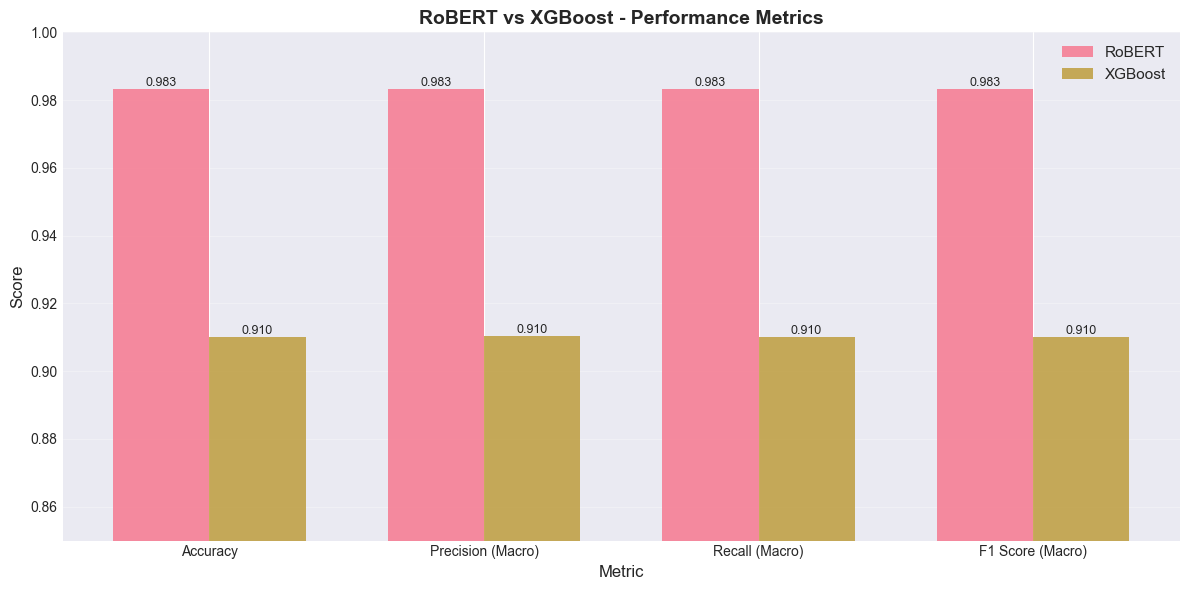

In [6]:
# Visualize metrics comparison
if robert_metrics and xgboost_metrics:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(len(comparison_df))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, comparison_df['RoBERT'], width, label='RoBERT', alpha=0.8)
    bars2 = ax.bar(x + width/2, comparison_df['XGBoost'], width, label='XGBoost', alpha=0.8)
    
    ax.set_xlabel('Metric', fontsize=12)
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('RoBERT vs XGBoost - Performance Metrics', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Metric'])
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0.85, 1.0])  # Focus on the relevant range
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.3f}',
                   ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

## 3. Confusion Matrix Comparison

Visualize confusion matrices side-by-side.

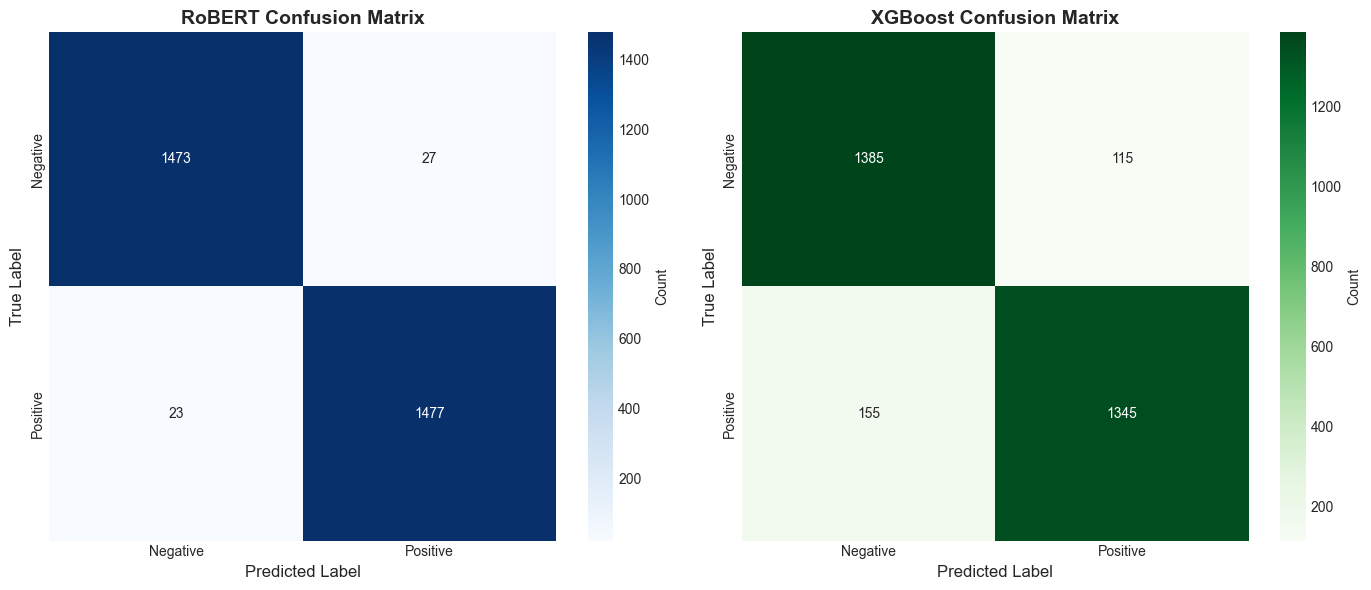


Error Rates:
  RoBERT:  1.67%
  XGBoost: 9.00%
  Difference: 7.33%


In [7]:
# Plot confusion matrices side by side
if robert_metrics and xgboost_metrics:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    class_names = ['Negative', 'Positive']
    
    # RoBERT confusion matrix
    robert_cm = np.array(robert_metrics.get('confusion_matrix', [[0, 0], [0, 0]]))
    sns.heatmap(robert_cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('RoBERT Confusion Matrix', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('True Label', fontsize=12)
    axes[0].set_xlabel('Predicted Label', fontsize=12)
    
    # XGBoost confusion matrix
    xgboost_cm = np.array(xgboost_metrics.get('confusion_matrix', [[0, 0], [0, 0]]))
    sns.heatmap(xgboost_cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Count'})
    axes[1].set_title('XGBoost Confusion Matrix', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('True Label', fontsize=12)
    axes[1].set_xlabel('Predicted Label', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate error rates
    robert_errors = (robert_cm[0, 1] + robert_cm[1, 0]) / robert_cm.sum()
    xgboost_errors = (xgboost_cm[0, 1] + xgboost_cm[1, 0]) / xgboost_cm.sum()
    
    print(f"\nError Rates:")
    print(f"  RoBERT:  {robert_errors:.2%}")
    print(f"  XGBoost: {xgboost_errors:.2%}")
    print(f"  Difference: {(xgboost_errors - robert_errors):.2%}")

## 4. Per-Class Performance

Compare precision, recall, and F1 for each class.

C:\Users\Tudor\AppData\Local\Temp\ipykernel_2876\687413956.py:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=2.0)


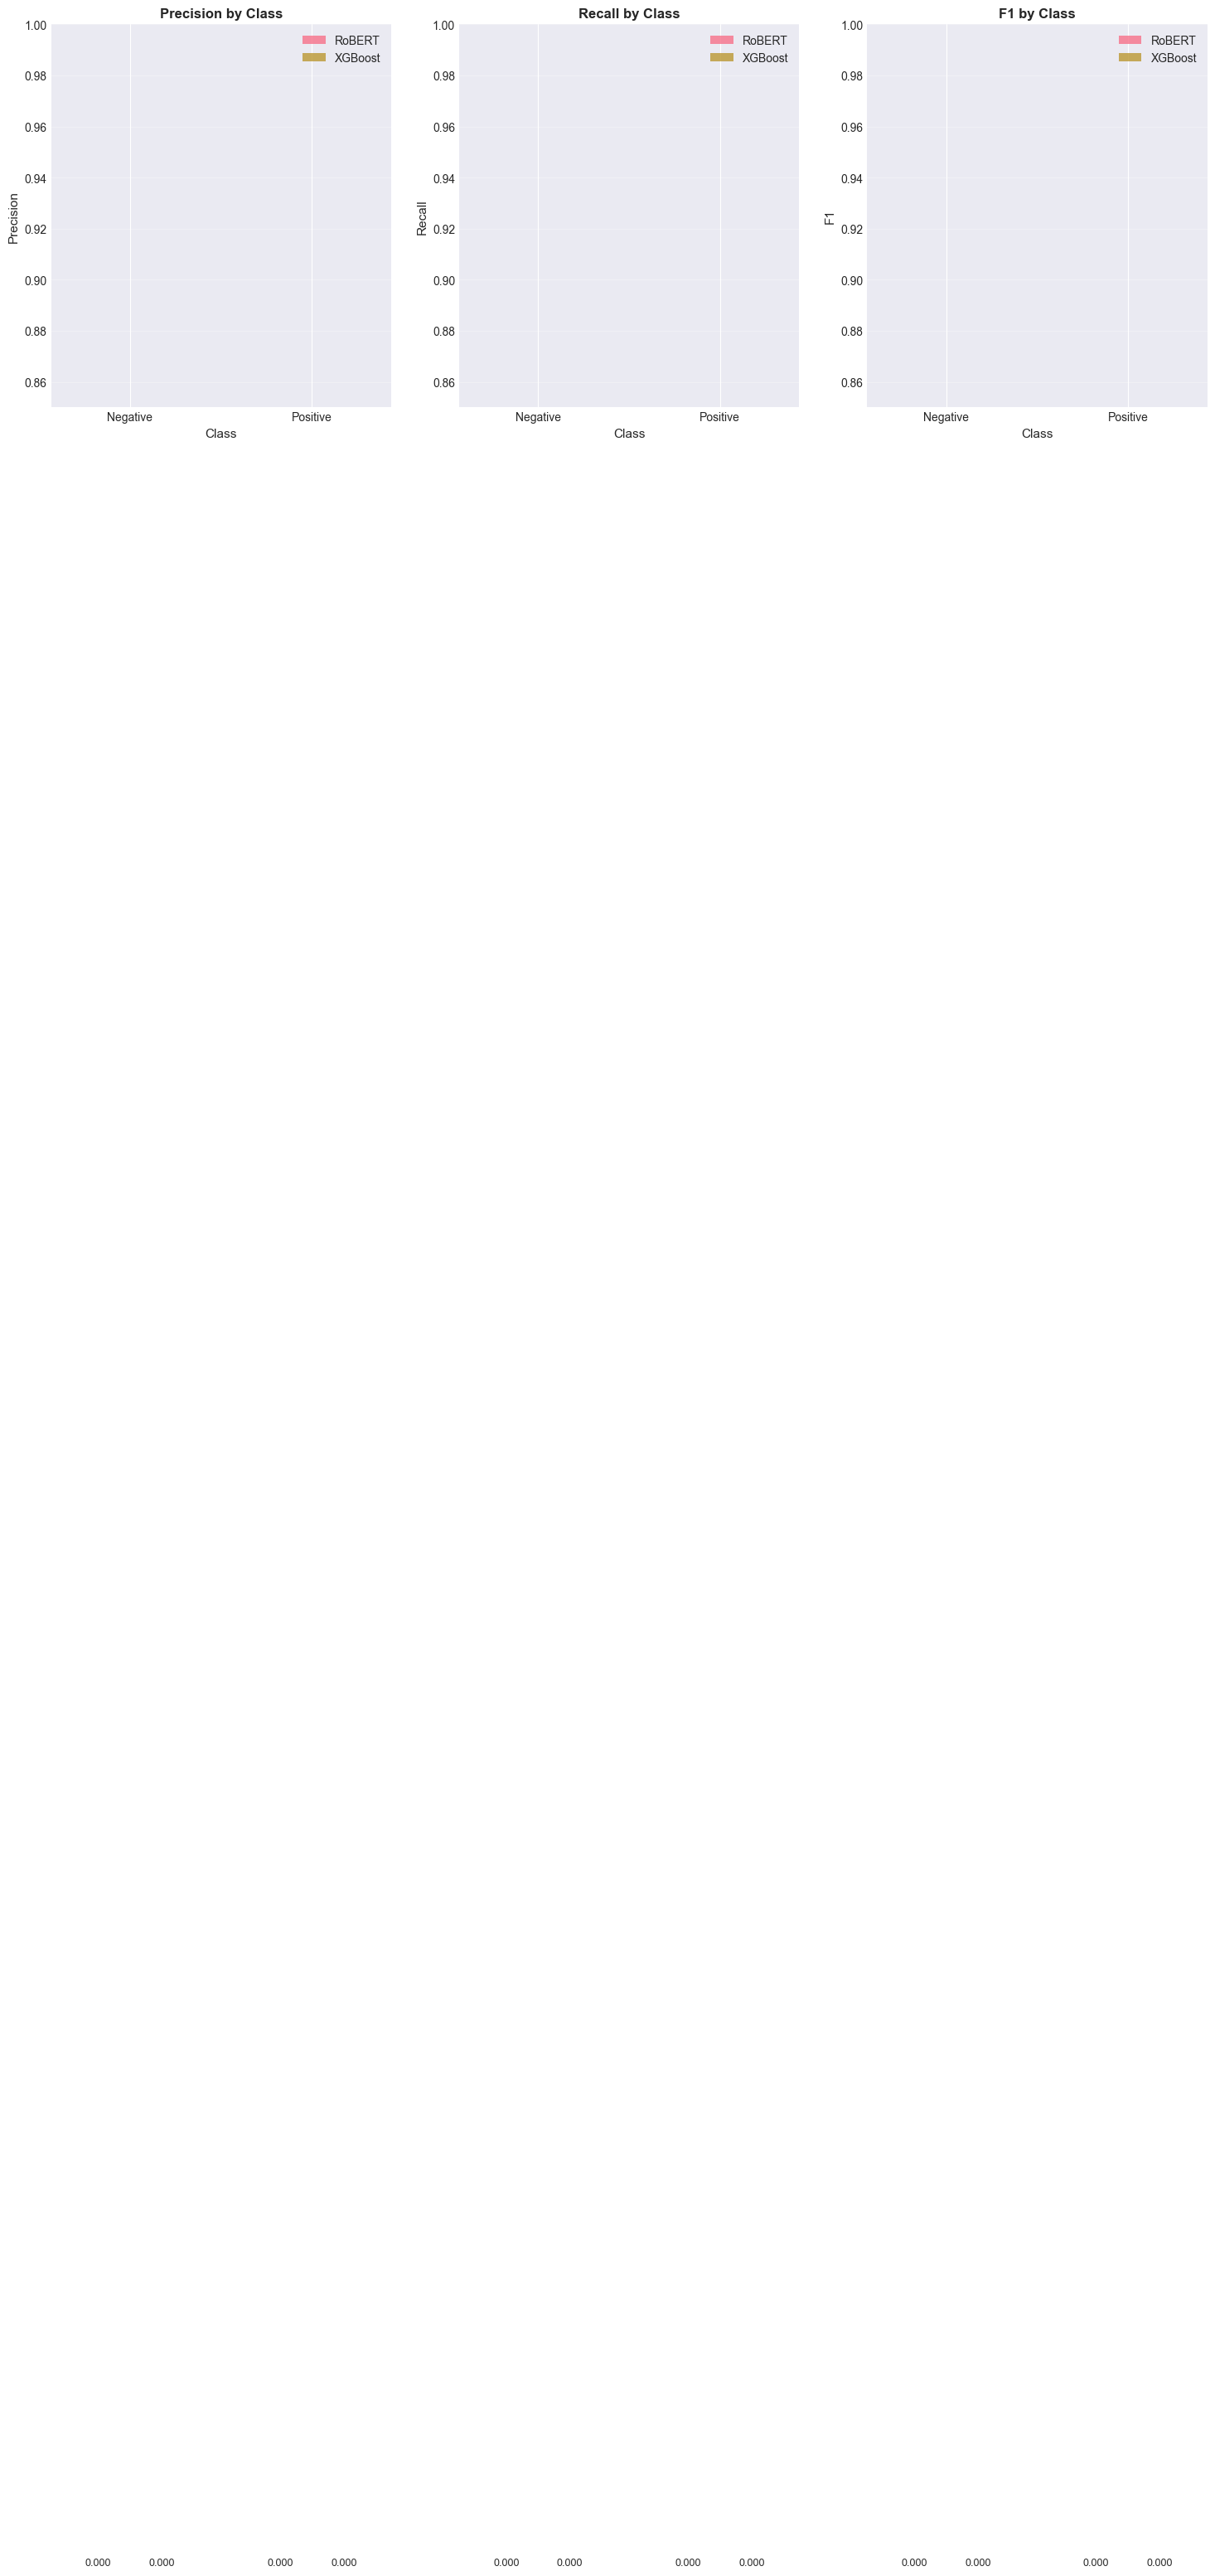

In [8]:
# Extract per-class metrics
if robert_metrics and xgboost_metrics:
    classes = ['Negative', 'Positive']
    metrics_to_compare = ['precision', 'recall', 'f1']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for idx, metric in enumerate(metrics_to_compare):
        robert_values = robert_metrics.get(f'{metric}_per_class', [0, 0])
        xgboost_values = xgboost_metrics.get(f'{metric}_per_class', [0, 0])
        
        x = np.arange(len(classes))
        width = 0.35
        
        axes[idx].bar(x - width/2, robert_values, width, label='RoBERT', alpha=0.8)
        axes[idx].bar(x + width/2, xgboost_values, width, label='XGBoost', alpha=0.8)
        
        axes[idx].set_xlabel('Class', fontsize=11)
        axes[idx].set_ylabel(metric.capitalize(), fontsize=11)
        axes[idx].set_title(f'{metric.capitalize()} by Class', fontsize=12, fontweight='bold')
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(classes)
        axes[idx].legend(fontsize=10)
        axes[idx].grid(axis='y', alpha=0.3)
        axes[idx].set_ylim([0.85, 1.0])
        
        # Add value labels
        for i, (r_val, x_val) in enumerate(zip(robert_values, xgboost_values)):
            axes[idx].text(i - width/2, r_val + 0.005, f'{r_val:.3f}', 
                          ha='center', fontsize=9)
            axes[idx].text(i + width/2, x_val + 0.005, f'{x_val:.3f}', 
                          ha='center', fontsize=9)
    
    plt.tight_layout(pad=2.0)
    plt.show()

## 5. Error Analysis

Analyze which samples each model gets wrong.

In [9]:
# Analyze predictions if available
if robert_preds is not None:
    # Find misclassified samples
    robert_errors = robert_preds[robert_preds['true_label'] != robert_preds['predicted_label']]
    
    print(f"\n📋 RoBERT Error Analysis")
    print("=" * 80)
    print(f"Total errors: {len(robert_errors)} / {len(robert_preds)} ({len(robert_errors)/len(robert_preds):.2%})")
    
    # Breakdown by class
    false_positives = robert_errors[robert_errors['true_label'] == 0]
    false_negatives = robert_errors[robert_errors['true_label'] == 1]
    
    print(f"\nFalse Positives (predicted positive, actually negative): {len(false_positives)}")
    print(f"False Negatives (predicted negative, actually positive): {len(false_negatives)}")
    
    # Show examples of errors
    if len(robert_errors) > 0:
        # Check if confidence column exists
        if 'confidence' in robert_errors.columns:
            print("\n🔍 Examples of Low-Confidence Errors (most uncertain):")
            uncertain_errors = robert_errors.nsmallest(5, 'confidence')
            
            for i, row in uncertain_errors.iterrows():
                true_sent = 'POSITIVE' if row['true_label'] == 1 else 'NEGATIVE'
                pred_sent = 'POSITIVE' if row['predicted_label'] == 1 else 'NEGATIVE'
                print(f"\n  Text: {row['text'][:100]}...")
                print(f"  True: {true_sent} | Predicted: {pred_sent} | Confidence: {row['confidence']:.2%}")
        else:
            print("\n🔍 Examples of Errors:")
            sample_errors = robert_errors.head(5)
            
            for i, row in sample_errors.iterrows():
                true_sent = 'POSITIVE' if row['true_label'] == 1 else 'NEGATIVE'
                pred_sent = 'POSITIVE' if row['predicted_label'] == 1 else 'NEGATIVE'
                print(f"\n  Text: {row['text'][:100]}...")
                print(f"  True: {true_sent} | Predicted: {pred_sent}")


📋 RoBERT Error Analysis
Total errors: 50 / 3000 (1.67%)

False Positives (predicted positive, actually negative): 27
False Negatives (predicted negative, actually positive): 23

🔍 Examples of Errors:

  Text: Bunicele sunet bun, sunt foarte mici, frumoase ca aspect si ca pachet, in convorbiri se aude bine da...
  True: POSITIVE | Predicted: NEGATIVE

  Text: Decente, daca nu se strica sunetul clar, puternic ne-deranjant. un pic cam grele. in rest sunt robus...
  True: POSITIVE | Predicted: NEGATIVE

  Text: Bun, insa... pentru un produs in plaja asta de pret este foarte ok. din nefericire vine fara niciun ...
  True: POSITIVE | Predicted: NEGATIVE

  Text: Super multumit la banii care i-am dat este super. comparabila cu boxe care depasesc 300 de lei....
  True: NEGATIVE | Predicted: POSITIVE

  Text: Imi place o bratara feminina care isi face bine treaba. se sincronizeaza foarte bine cu android - sa...
  True: NEGATIVE | Predicted: POSITIVE


## 6. Model Characteristics Comparison

Compare model architecture, size, and computational requirements.

In [10]:
# Create characteristics comparison
characteristics = pd.DataFrame({
    'Characteristic': [
        'Model Type',
        'Parameters',
        'Preprocessing',
        'Feature Engineering',
        'Training Time (approx)',
        'Inference Speed',
        'Model Size',
        'GPU Required',
        'Language Specific'
    ],
    'RoBERT': [
        'Transformer (BERT)',
        '~124M parameters',
        'Minimal (URL/HTML removal)',
        'Automatic (learned embeddings)',
        '1-3 hours',
        '~20ms per review',
        '~500MB',
        'Recommended',
        'Yes (Romanian BERT)'
    ],
    'XGBoost': [
        'Gradient Boosting',
        '~1M parameters',
        'Extensive (lemmatization)',
        'Manual (LF-MICF + IGWO)',
        '7-60 minutes',
        '<1ms per review',
        '~10MB',
        'No',
        'Language-agnostic'
    ]
})

print("\n⚙️ MODEL CHARACTERISTICS COMPARISON")
print("=" * 80)
print(characteristics.to_string(index=False))
print("=" * 80)


⚙️ MODEL CHARACTERISTICS COMPARISON
        Characteristic                         RoBERT                   XGBoost
            Model Type             Transformer (BERT)         Gradient Boosting
            Parameters               ~124M parameters            ~1M parameters
         Preprocessing     Minimal (URL/HTML removal) Extensive (lemmatization)
   Feature Engineering Automatic (learned embeddings)   Manual (LF-MICF + IGWO)
Training Time (approx)                      1-3 hours              7-60 minutes
       Inference Speed               ~20ms per review           <1ms per review
            Model Size                         ~500MB                     ~10MB
          GPU Required                    Recommended                        No
     Language Specific            Yes (Romanian BERT)         Language-agnostic


## 7. Summary and Recommendations

Provide final recommendations based on the comparison.

In [11]:
if robert_metrics and xgboost_metrics:
    robert_acc = robert_metrics.get('accuracy', 0)
    xgboost_acc = xgboost_metrics.get('accuracy', 0)
    
    print("\n" + "="*80)
    print("📝 SUMMARY AND RECOMMENDATIONS")
    print("="*80)
    
    print(f"\n📊 Final Scores:")
    print(f"  RoBERT:  {robert_acc:.2%} accuracy")
    print(f"  XGBoost: {xgboost_acc:.2%} accuracy")
    print(f"  Difference: {(robert_acc - xgboost_acc):.2%}")
    
    print("\n✅ When to Use RoBERT:")
    print("  • Maximum accuracy is critical")
    print("  • GPU is available for training and inference")
    print("  • Romanian language understanding is important")
    print("  • Inference latency <100ms is acceptable")
    print("  • Complex sentiment patterns need to be captured")
    
    print("\n✅ When to Use XGBoost:")
    print("  • Fast inference is critical (<1ms)")
    print("  • No GPU available")
    print("  • Small model size is important")
    print("  • Fast iteration during development")
    print("  • Resource-constrained deployment")
    
    print("\n🎯 Best Approach:")
    if robert_acc > xgboost_acc + 0.02:  # >2% better
        print("  → Use RoBERT for production (significantly better accuracy)")
        print("  → Keep XGBoost as fast baseline/fallback")
    elif robert_acc > xgboost_acc:
        print("  → Consider RoBERT for production (better accuracy)")
        print("  → XGBoost is a strong alternative if speed matters")
    else:
        print("  → Use XGBoost for production (similar accuracy, much faster)")
        print("  → RoBERT might not justify the extra complexity")
    
    print("\n💡 Ensemble Option:")
    print("  • Combine both models for best results")
    print("  • Use RoBERT for final decision, XGBoost as confidence check")
    print("  • Expected accuracy: +0.5-1.5% over best single model")
    
    print("\n" + "="*80)
else:
    print("⚠ Cannot provide recommendations - missing metrics")


📝 SUMMARY AND RECOMMENDATIONS

📊 Final Scores:
  RoBERT:  98.33% accuracy
  XGBoost: 91.00% accuracy
  Difference: 7.33%

✅ When to Use RoBERT:
  • Maximum accuracy is critical
  • GPU is available for training and inference
  • Romanian language understanding is important
  • Inference latency <100ms is acceptable
  • Complex sentiment patterns need to be captured

✅ When to Use XGBoost:
  • Fast inference is critical (<1ms)
  • No GPU available
  • Small model size is important
  • Fast iteration during development
  • Resource-constrained deployment

🎯 Best Approach:
  → Use RoBERT for production (significantly better accuracy)
  → Keep XGBoost as fast baseline/fallback

💡 Ensemble Option:
  • Combine both models for best results
  • Use RoBERT for final decision, XGBoost as confidence check
  • Expected accuracy: +0.5-1.5% over best single model



## 8. Export Comparison Report

Save comparison results for documentation.

In [12]:
# Export comparison to file
if robert_metrics and xgboost_metrics:
    report = {
        'comparison_date': datetime.now().isoformat(),
        'robert_experiment': str(robert_dir),
        'xgboost_experiment': str(xgboost_dir),
        'metrics_comparison': comparison_df.to_dict('records'),
        'winner': 'RoBERT' if robert_acc > xgboost_acc else 'XGBoost',
        'accuracy_difference': float(robert_acc - xgboost_acc),
        'robert_metrics': robert_metrics,
        'xgboost_metrics': xgboost_metrics
    }
    
    report_path = Path('../results/model_comparison_report.json')
    with open(report_path, 'w') as f:
        json.dump(report, f, indent=2)
    
    print(f"✅ Comparison report saved to: {report_path}")
else:
    print("⚠ Cannot export report - missing metrics")

✅ Comparison report saved to: ..\results\model_comparison_report.json
